# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

from tqdm.notebook import tqdm

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [5]:
def min_max_scaler(X):
    X = X.copy()
    for col in X:
        min_col = X[col].min()
        max_col = X[col].max()
        X[col] = (X[col] - min_col) / (max_col - min_col)

    return X

def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    X = pd.read_csv(path_to_csv).sample(frac = 1)
    y = X['label'].apply(lambda x: 1 if x == 'M' else 0)
    X.drop(columns=['label'], inplace=True)

    X = min_max_scaler(X)

    return X.values, y.values

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    X = pd.read_csv(path_to_csv).sample(frac = 1)
    y = X['label']
    X.drop(columns=['label'], inplace=True)

    X = min_max_scaler(X)

    return X.values, y.values

In [6]:
read_cancer_dataset("cancer.csv")

(array([[0.11557575, 0.61447413, 0.10690346, ..., 0.        , 0.17938104,
         0.09609078],
        [0.35207535, 0.34020967, 0.35028678, ..., 0.53780069, 0.22728169,
         0.25245966],
        [0.37053339, 0.16875211, 0.35153065, ..., 0.2733677 , 0.15158683,
         0.04184704],
        ...,
        [0.28439585, 0.15285763, 0.27841891, ..., 0.20103093, 0.17090479,
         0.30080021],
        [0.22618202, 0.28508624, 0.21567272, ..., 0.24604811, 0.08141139,
         0.09254887],
        [0.18074684, 0.        , 0.1726211 , ..., 0.15817869, 0.10348906,
         0.14397219]]),
 array([0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [7]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    mask = np.random.rand(len(X)) < ratio
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]

    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [8]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = np.unique(list(y_pred) + list(y_true))
    precision = np.array([])
    recall = np.array([])
    accuracy = sum(y_pred == y_true) / len(y_pred)

    for mark in classes:

        tp, tn, fp, fn = 0, 0, 0, 0

        for true, pred in zip(y_true, y_pred):
            if true == mark:
                if true == pred:
                    tp += 1
                else:
                    fp += 1
            else:
                if true == pred:
                    tn += 1
                else:
                    fn += 1

        prec = 0 if tp + fp == 0 else tp / (tp + fp)
        rec = 0 if tp + fn == 0 else tp / (tp + fn)
        precision = np.append(precision, prec)
        recall = np.append(recall, rec)

    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [9]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in tqdm(ks):
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [10]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in tqdm(ks):
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [291]:
class KDNode:
    def __init__(self, X: np.array):
        self.X = X
        self.parent = -1
        self.l_child = -1
        self.r_child = -1
        
        self.feature = -1
        self.median = -1

        self.visited = False

    
    def check_mask(self, X):
        return X.T[self.feature] < self.median

class KDTree:

    # Находит следующий признак для разбиения
    def __find_next_feature(self, feature, node):
        return self.__find_inner_next_feature(feature, node, 0, self.__max_n_calls)


    def __find_inner_next_feature(self, feature, node, n_calls, max_n_calls):
        feature = (feature + 1) % self.__X.shape[1]

        if n_calls > max_n_calls:
            return -1

        col = self.__X[node.X].T[feature]
        node.feature = feature
        node.median = np.median(col)

        first_part, second_part = self.__get_separation(node)

        if abs(len(first_part) - len(second_part)) > 2:
            return self.__find_inner_next_feature(feature, node, 
                                                  n_calls + 1, max_n_calls)
        else:
            return feature

    # Разделяет датасет по выбранному признаку
    def __get_separation(self, node):
        mask = node.check_mask(self.__X[node.X])
        return node.X[mask], node.X[~mask]


    # Создает детей по разбиению по признаку
    def __get_children(self, node):
        left_part, right_part = self.__get_separation(node)

        left_node = KDNode(left_part)
        left_node.parent = node
        node.l_child = left_node

        right_node = KDNode(right_part)
        right_node.parent = node
        node.r_child = right_node

        return left_node, right_node

    
    # Строит дерево для выбранного признака
    def __build_tree(self, node, feature):
        if len(node.X) > self.__leaf_size:
            node.feature = self.__find_next_feature(feature, node)

            if node.feature != -1:
                left_node, right_node = self.__get_children(node)

                self.__nodes.append(left_node)
                self.__nodes.append(right_node)
                
                self.__build_tree(left_node, node.feature)
                self.__build_tree(right_node, node.feature)
          

    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        self.__X = X
        self.__root = KDNode(np.array(range(X.shape[0])))
        self.__leaf_size = leaf_size
        self.__max_n_calls = self.__X.shape[1]
        self.__nodes = []

        feature = -1

        self.__build_tree(self.__root, feature)

    
    def __merge(self, left, right, key=lambda x: x):
        result = []
        i, j = 0, 0
        while i < len(left) and j < len(right) and len(result) < self.__k:
            if key(left[i]) < key(right[j]):
                result.append(left[i])
                i += 1
            else:
                result.append(right[j])
                j += 1
        while i < len(left) and len(result) < self.__k:
            result.append(left[i])
            i += 1
        while j < len(right) and len(result) < self.__k:
            result.append(right[j])
            j += 1

        return np.array(result)

    
    # Спускается в лист, где находится полученная точка
    def __get_start_node(self, row):
        node = self.__root
        while not node.l_child == -1 and not node.r_child == -1:
            if node.check_mask(row):
                node = node.l_child
            else:
                node = node.r_child

        return node

    
    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждог__all_not_visitedо списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        all_k_nearest = []
        self.__k = k

        for row in X:
            node = self.__get_start_node(row)
            self.__all_not_visited()

            k_nearest = self.__nearest_neighbours(row, node, np.array([]))

            all_k_nearest.append(k_nearest)

        return all_k_nearest

    
    def __all_not_visited(self):
        for node in self.__nodes:
            node.visited = False

    
    # Условие выбора заходить в лист или нет
    def __distance_condition(self, row, node, k_nearest):

        distance_to_k = np.linalg.norm(row - self.__X[k_nearest[-1]]) 
        distance_condition = distance_to_k >= self.__hyperplane_distance(row, node)
        k_condition = len(k_nearest) < self.__k

        return  distance_condition or k_condition


    # Расстояние до гиперплоскости
    def __hyperplane_distance(self, row, node):
        is_left = node.parent.l_child == node

        if row[node.parent.feature] < node.parent.median and is_left:
            return 0
        
        if row[node.parent.feature] >= node.parent.median and not is_left:
            return 0

        return np.abs(row[node.parent.feature] - node.parent.median)


    # Ищем ближайших соседей
    def __nearest_neighbours(self, point, node, k_nearest):
        if node.l_child != -1 and not node.l_child.visited:
            if self.__distance_condition(point, node.l_child, k_nearest):
                k_nearest = self.__nearest_neighbours(point, node.l_child, k_nearest)
        
        if node.r_child != -1 and not node.r_child.visited:
            if self.__distance_condition(point, node.r_child, k_nearest):
                k_nearest = self.__nearest_neighbours(point, node.r_child, k_nearest)

        if node.l_child == -1 and node.r_child == -1:
            array = sorted(node.X, key=lambda idx: 
                                  np.linalg.norm(point - self.__X[idx]))
            
            k_nearest = self.__merge(array, k_nearest, 
                                     key=lambda idx: np.linalg.norm(point - self.__X[idx]))

        node.visited = True

        if node.parent != -1:
            return self.__nearest_neighbours(point, node.parent, k_nearest)
        
        return k_nearest

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [292]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)

tree = KDTree(X_train, leaf_size=4)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [293]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.__n_neighbors = n_neighbors
        self.__leaf_size = leaf_size
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self.__tree = KDTree(X, leaf_size=self.__leaf_size)
        self.__target = y
        self.__n_classes = len(np.unique(y))
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """

        predicted = self.__tree.query(X, k=self.__n_neighbors)
        predicted_classes = []

        for i, row in enumerate(predicted):
            predicted_classes.append(self.__target[predicted[i]])
        

        proba = np.zeros((X.shape[0], self.__n_classes))
        for i in range(self.__n_classes):
            for j, row in enumerate(predicted_classes):
                proba[j][i] = sum([int(x == i) for x in row]) / len(row)

        return proba



        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns        print(X)
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

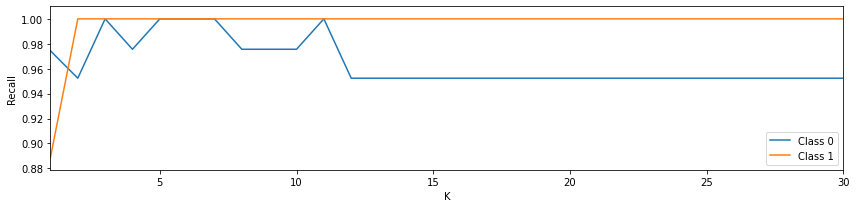

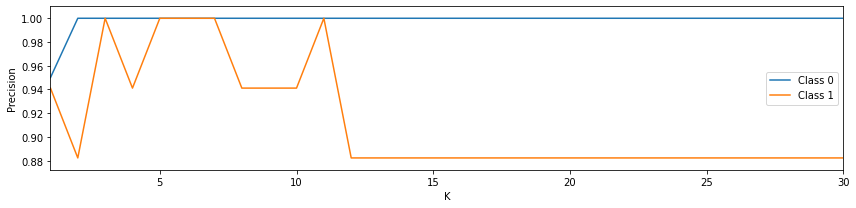

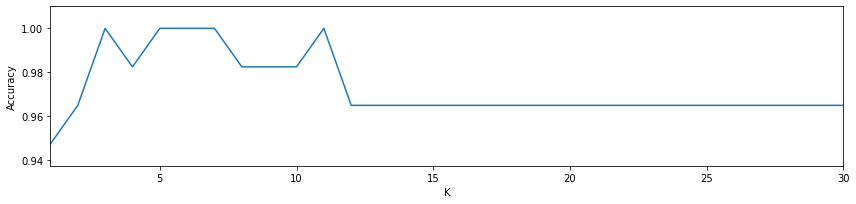

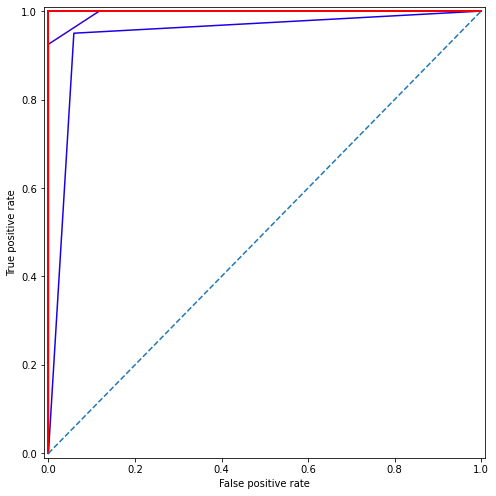

CPU times: user 26.9 s, sys: 612 ms, total: 27.5 s
Wall time: 27.5 s


In [294]:
%%time

X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

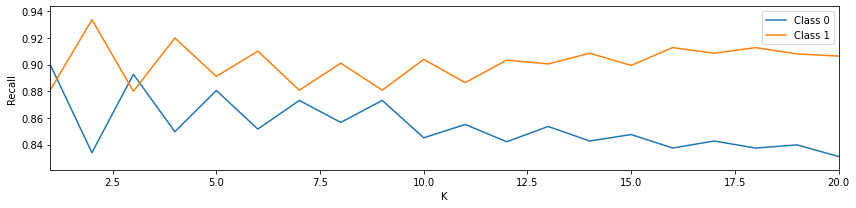

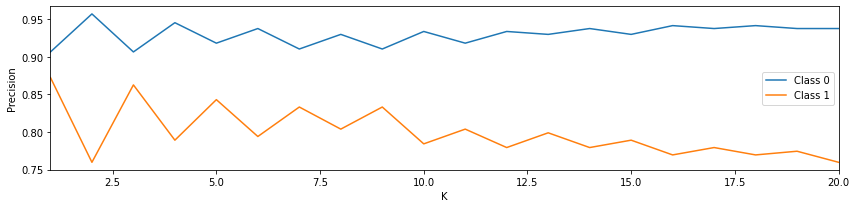

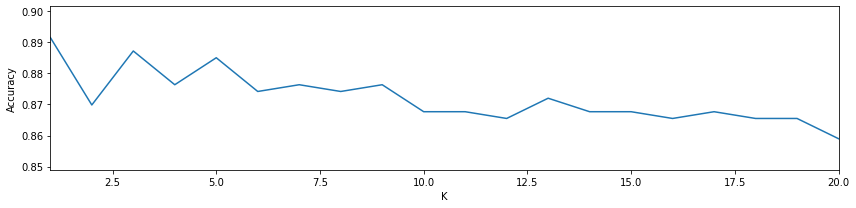

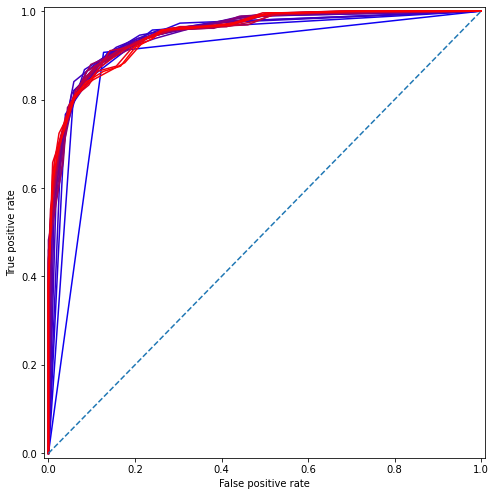

CPU times: user 18min 27s, sys: 5.69 s, total: 18min 32s
Wall time: 18min 30s


In [214]:
  %%time

X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)